In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install --upgrade ipykernel
## install finrl library
!pip install -q condacolab
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

## Preprocessing

In [183]:
%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import pandas as pd

### Create Folders

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

TRAIN_START_DATE = '2010-01-04'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

df.sort_values(['date','tic'],ignore_index=True).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488928,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080162,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385945,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880190,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150225,8449400,XLK,0


In [3]:
#split data ticker wise
df_XLB = df[df['tic']=='XLB'][['date','tic','close']]
df_XLE = df[df['tic']=='XLE'][['date','tic','close']]
df_XLF = df[df['tic']=='XLF'][['date','tic','close']]
df_XLI = df[df['tic']=='XLI'][['date','tic','close']]
df_XLK = df[df['tic']=='XLK'][['date','tic','close']]
df_XLP = df[df['tic']=='XLP'][['date','tic','close']]
df_XLU = df[df['tic']=='XLU'][['date','tic','close']]
df_XLV = df[df['tic']=='XLV'][['date','tic','close']]
df_XLY = df[df['tic']=='XLY'][['date','tic','close']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Dlinear
D = pd.DataFrame({'XLB':df_XLB['close'].values,
                    'XLE':df_XLE['close'].values,
                    'XLF':df_XLF['close'].values,
                    'XLI':df_XLI['close'].values,
                    'XLK':df_XLK['close'].values,
                    'XLP':df_XLP['close'].values,
                    'XLU':df_XLU['close'].values,
                    'XLV':df_XLV['close'].values,
                    'XLY':df_XLY['close'].values},index=df_XLB['date'].values)

D.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
2010-01-04,25.488926,38.080177,9.385944,21.880180,19.150225,18.718466,19.481915,25.213634,25.227169
2010-01-05,25.571346,38.390965,9.558456,21.957451,19.125538,18.725473,19.249990,24.966358,25.319672
2010-01-06,26.005892,38.850704,9.577625,22.003805,18.911566,18.711445,19.362825,25.221619,25.353300
2010-01-07,25.803596,38.792431,9.782081,22.243319,18.837503,18.711445,19.275064,25.309353,25.563526
2010-01-08,26.163239,39.044956,9.724576,22.598709,18.960941,18.648277,19.256262,25.349237,25.555117


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [27]:
D = pd.read_csv('/content/drive/MyDrive/kubig_financial/D.csv')
D.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
D.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,2010-01-04,25.488928,38.080162,9.385947,21.880188,19.150221,18.718464,19.481915,25.213638,25.227169
1,2010-01-05,25.571354,38.390972,9.558456,21.957457,19.125528,18.725483,19.249992,24.966366,25.319664
2,2010-01-06,26.005892,38.850708,9.577625,22.003801,18.911566,18.711449,19.362823,25.221615,25.353292
3,2010-01-07,25.803612,38.792439,9.782079,22.243311,18.837500,18.711449,19.275064,25.309351,25.563526
4,2010-01-08,26.163239,39.044956,9.724579,22.598709,18.960951,18.648277,19.256264,25.349237,25.555117


In [149]:
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-01'

TRAIN_VAL_DATE = '2020-01-03'
TRADE_VAL_DATE = '2023-01-04'

In [152]:
TRAIN_END_INDEX = D[D.date==TRAIN_END_DATE].index[0]
TRADE_START_INDEX = D[D.date==TRAIN_END_DATE].index[0]
TRADE_END_INDEX = D[D.date==TRADE_END_DATE].index[0]

TRAIN_VAL_INDEX = D[D.date==TRAIN_VAL_DATE].index[0]
TRADE_VAL_INDEX = D[D.date==TRADE_VAL_DATE].index[0]

print(TRAIN_END_INDEX)
print(TRADE_END_INDEX)

2957
3353


In [162]:
train_df = D.loc[:TRAIN_END_INDEX]
test_df = D.loc[TRADE_START_INDEX:TRADE_END_INDEX]
test_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
test_df.head()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,2021-10-01,77.827316,50.451199,37.005863,96.721664,149.482285,66.495392,61.087296,124.416832,178.426147
1,2021-10-04,77.488388,51.275818,36.685760,96.195053,146.020630,66.283440,61.928818,122.521217,177.014908
2,2021-10-05,78.175919,51.575668,37.403564,97.267784,148.101547,66.620644,61.775818,123.254059,177.725464
3,2021-10-06,78.030670,51.032177,37.442368,97.696877,149.068054,67.266129,62.732098,123.029320,178.287964
4,2021-10-07,79.047447,51.425747,37.665474,98.457550,150.429031,67.564796,62.397396,124.661110,181.061081


### Preprocessing Code

In [318]:
def standardization(train_df, test_df, not_col):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean = train_df[x].mean()
        std = train_df[x].std()
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list, std_list

def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

###DLinear Code

In [252]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

## Execution Code

In [319]:
### parameters
window_size = 72
forcast_size= 1
batch_size = 32
targets = list(D.columns)[1:]
date = 'date'

train_loss_list = []
valid_loss_list = []
test_loss_list = []
dlinear_prediction = []
epoch = 20
lr = 0.001
###############


### 데이터 정규화
train_df_fe, test_df_fe, mean_list, std_list = standardization(train_df, test_df, date)

for tar in targets:
  ### timestep 지정
  train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, tar)
  test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, tar)

  ### DataLoader
  train_ds = Data(train_x[:TRAIN_VAL_INDEX], train_y[:TRAIN_VAL_INDEX])
  valid_ds = Data(train_x[TRADE_VAL_INDEX:], train_y[TRADE_VAL_INDEX:])
  test_ds = Data(test_x, test_y)

  train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle=False)
  test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)


  ### Dlinear
  DLinear_model = LTSF_DLinear(
      window_size=window_size,
      forcast_size=forcast_size,
      kernel_size=25,
      individual=False,
      feature_size=1,
  )
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
  max_loss = 999999999

  ### training
  for epoch in tqdm(range(1, epoch+1)):
      
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    valid_loss = 0
    test_loss = 0
    with torch.no_grad():
      if len(valid_dl) > 0:
          for data, target in valid_dl:
              output = DLinear_model(data)
              valid_loss += criterion(output, target.unsqueeze(-1)).item()
          valid_loss /= len(valid_dl)
          valid_loss_list.append(valid_loss)
      if len(test_dl) > 0:         
          for data, target in test_dl:
              output = DLinear_model(data)
              test_loss += criterion(output, target.unsqueeze(-1)).item()
          test_loss /= len(test_dl)
          test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, f'DLinear_model_{tar}.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_loss={:.3f}, Model Saved".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = valid_loss
        dlinear_best_test_loss = test_loss

    print("epoch = {}, train_loss: {:.3f}, valid_loss: {:.3f}, test_loss: {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))


  ### predict
  best_model = torch.load(f"DLinear_model_{tar}.pth")

  # 예측 모드로 설정
  best_model.eval()
  predictions = []
  
  with torch.no_grad():
      for data, target in test_dl:
          output = best_model(data)
          predictions.append(output.squeeze().tolist())
  
  pred = list(itertools.chain(*predictions))
  dlinear_prediction.append(pred)

 10%|█         | 2/20 [00:00<00:02,  6.43it/s]

valid_loss=0.000, test_loss=0.043, Model Saved
epoch = 1, train_loss: 0.016, valid_loss: 0.000, test_loss: 0.043
epoch = 2, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.031


 20%|██        | 4/20 [00:00<00:02,  6.27it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.020
epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.015


 30%|███       | 6/20 [00:00<00:02,  6.27it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.012
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.011


 40%|████      | 8/20 [00:01<00:01,  6.27it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 50%|█████     | 10/20 [00:01<00:01,  6.16it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 60%|██████    | 12/20 [00:01<00:01,  6.12it/s]

epoch = 11, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.013
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.012


 70%|███████   | 14/20 [00:02<00:00,  6.20it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 80%|████████  | 16/20 [00:02<00:00,  6.10it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 90%|█████████ | 18/20 [00:02<00:00,  6.24it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 18, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


100%|██████████| 20/20 [00:03<00:00,  6.24it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008



 10%|█         | 2/20 [00:00<00:02,  6.53it/s]

valid_loss=0.000, test_loss=0.193, Model Saved
epoch = 1, train_loss: 0.077, valid_loss: 0.000, test_loss: 0.193
epoch = 2, train_loss: 0.029, valid_loss: 0.000, test_loss: 0.124


 20%|██        | 4/20 [00:00<00:02,  6.47it/s]

epoch = 3, train_loss: 0.018, valid_loss: 0.000, test_loss: 0.098
epoch = 4, train_loss: 0.013, valid_loss: 0.000, test_loss: 0.071


 30%|███       | 6/20 [00:00<00:02,  6.27it/s]

epoch = 5, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.063
epoch = 6, train_loss: 0.009, valid_loss: 0.000, test_loss: 0.055


 40%|████      | 8/20 [00:01<00:01,  6.27it/s]

epoch = 7, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.044
epoch = 8, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.041


 45%|████▌     | 9/20 [00:01<00:01,  6.04it/s]

epoch = 9, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.050


 50%|█████     | 10/20 [00:01<00:01,  5.22it/s]

epoch = 10, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.044


 55%|█████▌    | 11/20 [00:01<00:01,  4.62it/s]

epoch = 11, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037


 60%|██████    | 12/20 [00:02<00:01,  4.41it/s]

epoch = 12, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037


 65%|██████▌   | 13/20 [00:02<00:01,  4.20it/s]

epoch = 13, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.038


 70%|███████   | 14/20 [00:02<00:01,  3.95it/s]

epoch = 14, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.039


 75%|███████▌  | 15/20 [00:03<00:01,  3.95it/s]

epoch = 15, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.038


 80%|████████  | 16/20 [00:03<00:01,  3.94it/s]

epoch = 16, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037


 85%|████████▌ | 17/20 [00:03<00:00,  3.95it/s]

epoch = 17, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.037


 90%|█████████ | 18/20 [00:03<00:00,  3.94it/s]

epoch = 18, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.039


 95%|█████████▌| 19/20 [00:04<00:00,  3.88it/s]

epoch = 19, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.044


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]

epoch = 20, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.044



  5%|▌         | 1/20 [00:00<00:05,  3.69it/s]

valid_loss=0.000, test_loss=0.044, Model Saved
epoch = 1, train_loss: 0.044, valid_loss: 0.000, test_loss: 0.044


 10%|█         | 2/20 [00:00<00:05,  3.58it/s]

epoch = 2, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.031


 15%|█▌        | 3/20 [00:00<00:04,  3.42it/s]

epoch = 3, train_loss: 0.005, valid_loss: 0.000, test_loss: 0.022


 20%|██        | 4/20 [00:01<00:04,  3.46it/s]

epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.014


 25%|██▌       | 5/20 [00:01<00:04,  3.51it/s]

epoch = 5, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.013


 30%|███       | 6/20 [00:01<00:04,  3.49it/s]

epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.010


 35%|███▌      | 7/20 [00:02<00:03,  3.49it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 40%|████      | 8/20 [00:02<00:03,  3.52it/s]

epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 45%|████▌     | 9/20 [00:02<00:03,  3.52it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:02<00:02,  3.51it/s]

epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 55%|█████▌    | 11/20 [00:03<00:02,  3.55it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 60%|██████    | 12/20 [00:03<00:02,  3.56it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 65%|██████▌   | 13/20 [00:03<00:01,  3.61it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:03<00:01,  3.60it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 75%|███████▌  | 15/20 [00:04<00:01,  3.64it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 80%|████████  | 16/20 [00:04<00:01,  3.64it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 90%|█████████ | 18/20 [00:04<00:00,  4.24it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006



 10%|█         | 2/20 [00:00<00:02,  6.47it/s]

valid_loss=0.000, test_loss=0.032, Model Saved
epoch = 1, train_loss: 0.016, valid_loss: 0.000, test_loss: 0.032
epoch = 2, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.017


 20%|██        | 4/20 [00:00<00:02,  6.47it/s]

epoch = 3, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.015
epoch = 4, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.011


 30%|███       | 6/20 [00:00<00:02,  6.40it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 6, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.007


 40%|████      | 8/20 [00:01<00:01,  6.38it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 50%|█████     | 10/20 [00:01<00:01,  6.12it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 60%|██████    | 12/20 [00:01<00:01,  6.17it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 65%|██████▌   | 13/20 [00:02<00:01,  6.06it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 70%|███████   | 14/20 [00:02<00:01,  5.45it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 75%|███████▌  | 15/20 [00:02<00:01,  3.59it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 80%|████████  | 16/20 [00:03<00:01,  3.31it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 85%|████████▌ | 17/20 [00:03<00:00,  3.13it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 95%|█████████▌| 19/20 [00:04<00:00,  3.63it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 10%|█         | 2/20 [00:00<00:03,  5.78it/s]

valid_loss=0.000, test_loss=0.063, Model Saved
epoch = 1, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.063
epoch = 2, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.048


 20%|██        | 4/20 [00:00<00:02,  6.10it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.027
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.019


 30%|███       | 6/20 [00:00<00:02,  6.16it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.016
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.016


 40%|████      | 8/20 [00:01<00:02,  5.99it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.013
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011


 50%|█████     | 10/20 [00:01<00:01,  6.02it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 60%|██████    | 12/20 [00:01<00:01,  6.18it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:02<00:00,  6.11it/s]

epoch = 13, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008
epoch = 14, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 80%|████████  | 16/20 [00:02<00:00,  6.04it/s]

epoch = 15, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.009
epoch = 16, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 90%|█████████ | 18/20 [00:02<00:00,  6.13it/s]

epoch = 17, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008
epoch = 18, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


100%|██████████| 20/20 [00:03<00:00,  6.09it/s]

epoch = 19, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008
epoch = 20, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.007



  5%|▌         | 1/20 [00:00<00:03,  4.86it/s]

valid_loss=0.000, test_loss=0.024, Model Saved
epoch = 1, train_loss: 0.010, valid_loss: 0.000, test_loss: 0.024


 10%|█         | 2/20 [00:00<00:04,  4.21it/s]

epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.016


 15%|█▌        | 3/20 [00:00<00:04,  3.99it/s]

epoch = 3, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.011


 20%|██        | 4/20 [00:00<00:04,  3.97it/s]

epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009


 25%|██▌       | 5/20 [00:01<00:03,  3.91it/s]

epoch = 5, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 30%|███       | 6/20 [00:01<00:03,  3.79it/s]

epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 35%|███▌      | 7/20 [00:01<00:03,  3.84it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


 40%|████      | 8/20 [00:02<00:03,  3.85it/s]

epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 45%|████▌     | 9/20 [00:02<00:02,  3.89it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010


 50%|█████     | 10/20 [00:02<00:02,  3.84it/s]

epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 55%|█████▌    | 11/20 [00:02<00:02,  3.35it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 60%|██████    | 12/20 [00:03<00:02,  2.68it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 65%|██████▌   | 13/20 [00:04<00:04,  1.71it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:05<00:04,  1.32it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 75%|███████▌  | 15/20 [00:06<00:04,  1.24it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 80%|████████  | 16/20 [00:07<00:02,  1.38it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 85%|████████▌ | 17/20 [00:07<00:02,  1.49it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 90%|█████████ | 18/20 [00:08<00:01,  1.53it/s]

epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 95%|█████████▌| 19/20 [00:08<00:00,  1.55it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004



  5%|▌         | 1/20 [00:00<00:05,  3.31it/s]

valid_loss=0.000, test_loss=0.047, Model Saved
epoch = 1, train_loss: 0.013, valid_loss: 0.000, test_loss: 0.047


 10%|█         | 2/20 [00:00<00:04,  3.81it/s]

epoch = 2, train_loss: 0.008, valid_loss: 0.000, test_loss: 0.029


 15%|█▌        | 3/20 [00:00<00:04,  4.14it/s]

epoch = 3, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.019


 20%|██        | 4/20 [00:01<00:04,  3.75it/s]

epoch = 4, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.016


 25%|██▌       | 5/20 [00:01<00:04,  3.32it/s]

epoch = 5, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.012


 30%|███       | 6/20 [00:01<00:04,  3.29it/s]

epoch = 6, train_loss: 0.003, valid_loss: 0.000, test_loss: 0.010


 40%|████      | 8/20 [00:02<00:02,  4.16it/s]

epoch = 7, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.009
epoch = 8, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008


 50%|█████     | 10/20 [00:02<00:02,  4.95it/s]

epoch = 9, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.008
epoch = 10, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.007


 60%|██████    | 12/20 [00:02<00:01,  5.48it/s]

epoch = 11, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.013
epoch = 12, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.007


 70%|███████   | 14/20 [00:03<00:01,  5.76it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 80%|████████  | 16/20 [00:03<00:00,  5.77it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010


 90%|█████████ | 18/20 [00:03<00:00,  5.97it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007



 10%|█         | 2/20 [00:00<00:02,  6.23it/s]

valid_loss=0.000, test_loss=0.020, Model Saved
epoch = 1, train_loss: 0.006, valid_loss: 0.000, test_loss: 0.020
epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.013


 20%|██        | 4/20 [00:00<00:02,  6.25it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.011
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.007


 30%|███       | 6/20 [00:00<00:02,  6.08it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 40%|████      | 8/20 [00:01<00:01,  6.10it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005
epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


 50%|█████     | 10/20 [00:01<00:01,  6.14it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.005


 60%|██████    | 12/20 [00:01<00:01,  6.15it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 70%|███████   | 14/20 [00:02<00:00,  6.17it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 80%|████████  | 16/20 [00:02<00:00,  6.13it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003


 90%|█████████ | 18/20 [00:02<00:00,  6.05it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003
epoch = 18, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.004


100%|██████████| 20/20 [00:03<00:00,  6.12it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.006
epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.003



 10%|█         | 2/20 [00:00<00:02,  6.29it/s]

valid_loss=0.000, test_loss=0.061, Model Saved
epoch = 1, train_loss: 0.007, valid_loss: 0.000, test_loss: 0.061
epoch = 2, train_loss: 0.004, valid_loss: 0.000, test_loss: 0.029


 20%|██        | 4/20 [00:00<00:02,  6.15it/s]

epoch = 3, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.022
epoch = 4, train_loss: 0.002, valid_loss: 0.000, test_loss: 0.016


 30%|███       | 6/20 [00:00<00:02,  6.12it/s]

epoch = 5, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.015
epoch = 6, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.013


 35%|███▌      | 7/20 [00:01<00:02,  5.27it/s]

epoch = 7, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.011


 40%|████      | 8/20 [00:01<00:02,  4.72it/s]

epoch = 8, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 45%|████▌     | 9/20 [00:01<00:02,  4.39it/s]

epoch = 9, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.010


 50%|█████     | 10/20 [00:02<00:02,  4.10it/s]

epoch = 10, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 55%|█████▌    | 11/20 [00:02<00:02,  3.96it/s]

epoch = 11, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 60%|██████    | 12/20 [00:02<00:02,  3.92it/s]

epoch = 12, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 65%|██████▌   | 13/20 [00:02<00:01,  3.89it/s]

epoch = 13, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.008


 70%|███████   | 14/20 [00:03<00:01,  3.78it/s]

epoch = 14, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.009


 75%|███████▌  | 15/20 [00:03<00:01,  3.83it/s]

epoch = 15, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 80%|████████  | 16/20 [00:03<00:01,  3.82it/s]

epoch = 16, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 85%|████████▌ | 17/20 [00:03<00:00,  3.83it/s]

epoch = 17, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


 90%|█████████ | 18/20 [00:04<00:00,  3.79it/s]

epoch = 18, train_loss: 0.000, valid_loss: 0.000, test_loss: 0.008


 95%|█████████▌| 19/20 [00:04<00:00,  3.82it/s]

epoch = 19, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


100%|██████████| 20/20 [00:04<00:00,  4.28it/s]

epoch = 20, train_loss: 0.001, valid_loss: 0.000, test_loss: 0.007


In [230]:
targets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

In [246]:
print(len(dlinear_prediction[0]))
print(len(test_df_fe.iloc[window_size:]))

325
325


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [247]:
len(dlinear_prediction)
test_df_pred = test_df_fe.iloc[window_size:].copy()

for i in range(len(targets)):
  test_df_pred[targets[i]] = dlinear_prediction[i]

test_df_pred.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
72,2022-01-13,3.130335,0.699450,2.771857,2.475583,3.397466,2.342203,2.196213,2.526559,3.127998
73,2022-01-14,3.128577,0.739067,2.785532,2.478162,3.401376,2.349685,2.198093,2.525115,3.131764
74,2022-01-18,3.121519,0.791714,2.791806,2.477319,3.401948,2.358695,2.202090,2.522659,3.134821
75,2022-01-19,3.110420,0.840614,2.789774,2.471502,3.399833,2.362242,2.198897,2.517073,3.136238
76,2022-01-20,3.097809,0.884011,2.782068,2.462736,3.392124,2.365257,2.198364,2.510440,3.130620


In [264]:
### destandardization
def inverse_standardization(test_df, not_col):
    test_df_ = test_df.copy()
    col = [col for col in list(train_df.columns) if col not in [not_col]]
    
    for x in range(len(targets)):
        mean = mean_list[x]
        std = std_list[x]
        test_df_.iloc[:, x+1] = (test_df_.iloc[:, x+1] * std) + mean
    
    return test_df_


test_df_pred_ds = inverse_standardization(test_df_pred, date)

In [276]:
test_df_pred_ds[180:].tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
392,2023-04-25,80.775246,83.097680,32.819523,99.751150,145.153192,74.168045,68.670095,131.816509,149.743375
393,2023-04-26,80.561866,83.034284,32.777525,99.604052,145.104697,74.277509,68.678056,131.864735,149.700367
394,2023-04-27,80.285442,82.834151,32.711388,99.284641,145.000464,74.335344,68.611609,131.742264,149.588161
395,2023-04-28,80.156669,82.769869,32.686694,99.167585,145.114344,74.406578,68.611411,131.720408,149.569231
396,2023-05-01,80.141388,82.872641,32.677252,99.082710,145.344728,74.470780,68.604167,131.727423,149.683807


In [277]:
test_df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
392,2023-04-25,79.489998,84.660004,32.570000,98.989998,143.970001,76.779999,69.900002,133.610001,144.429993
393,2023-04-26,78.550003,83.529999,32.259998,97.120003,146.110001,76.180000,68.260002,131.710007,143.690002
394,2023-04-27,79.620003,83.830002,32.779999,99.040001,149.210007,77.029999,69.080002,132.399994,147.479996
395,2023-04-28,80.550003,85.129997,33.169998,100.000000,150.830002,77.440002,68.980003,133.529999,147.860001
396,2023-05-01,80.510002,84.169998,33.080002,100.540001,150.919998,77.500000,69.099998,134.220001,146.399994


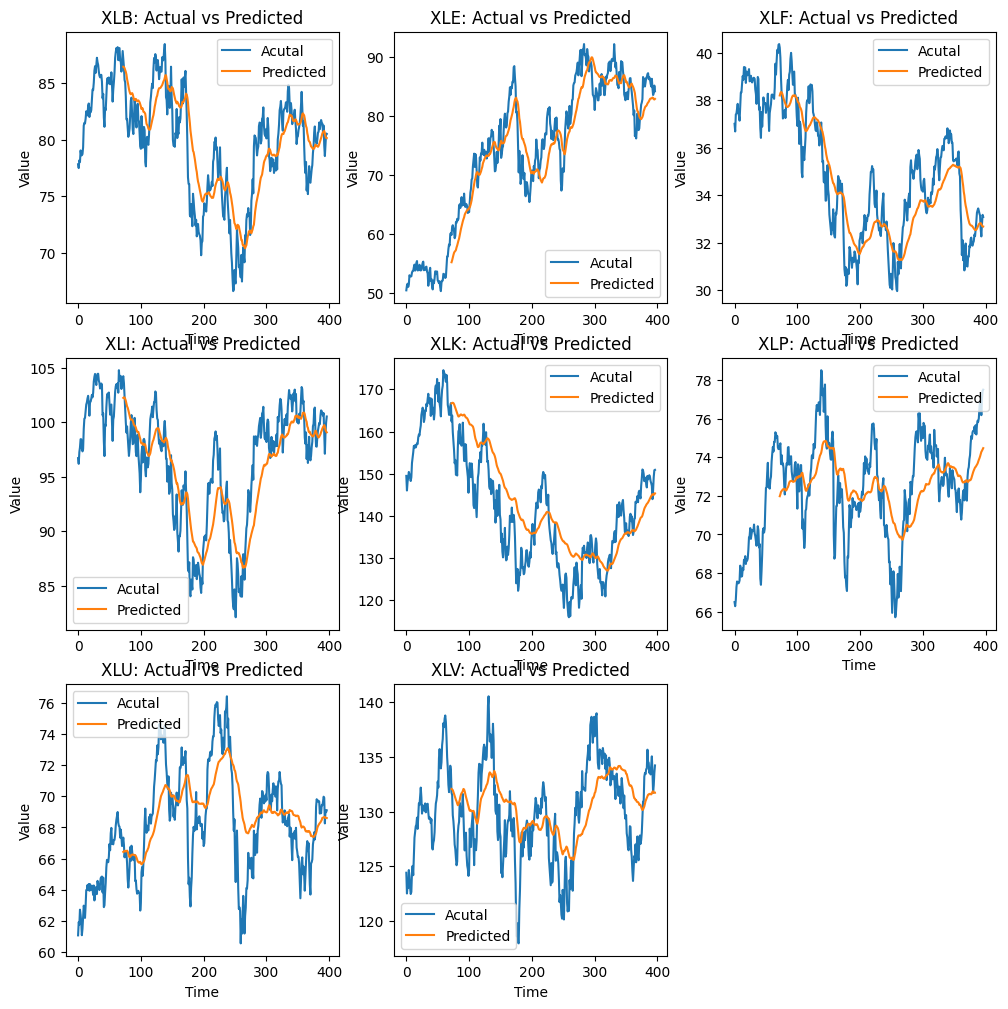

In [304]:
# 그래프 그리기
plt.figure(figsize=(12, 12))
for i in range(len(targets)-1):
  plt.subplot(3,3,i+1)
  plt.plot(test_df[targets[i]], label='Acutal')
  plt.plot(test_df_pred_ds[targets[i]], label='Predicted')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title(f'{targets[i]}: Actual vs Predicted')
  plt.legend()

In [306]:
test_df_pred_ds.to_csv('/content/drive/MyDrive/kubig_financial/DLinear.csv')

## Execution Code 2

In [311]:
df_fe = pd.concat([train_df_fe, test_df_fe])
df_fe

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
0,2010-01-04,-1.257581,-1.282793,-1.212013,-1.441745,-0.959033,-1.577020,-1.379345,-1.334136,-1.305590
1,2010-01-05,-1.251648,-1.246827,-1.188165,-1.437979,-0.959762,-1.576503,-1.397006,-1.343069,-1.303282
2,2010-01-06,-1.220374,-1.193629,-1.185515,-1.435720,-0.966081,-1.577536,-1.388414,-1.333847,-1.302443
3,2010-01-07,-1.234932,-1.200371,-1.157251,-1.424045,-0.968268,-1.577536,-1.395097,-1.330678,-1.297196
4,2010-01-08,-1.209049,-1.171151,-1.165200,-1.406722,-0.964622,-1.582184,-1.396529,-1.329237,-1.297406
...,...,...,...,...,...,...,...,...,...,...
392,2023-04-25,2.628995,4.107227,1.992993,2.316795,2.727173,2.695363,2.460148,2.582160,1.669368
393,2023-04-26,2.561342,3.976468,1.950138,2.225647,2.790372,2.651213,2.335257,2.513514,1.650900
394,2023-04-27,2.638352,4.011183,2.022024,2.319233,2.881922,2.713759,2.397702,2.538443,1.745487
395,2023-04-28,2.705286,4.161613,2.075938,2.366026,2.929764,2.743929,2.390087,2.579269,1.754971


In [320]:
def time_slide_df_ver2(df, window_size, forecast_size, date, target):
    df_ = df.reset_index(drop=True)  # Reset the index to avoid non-unique labels
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
### parameters
window_size = 72
forcast_size= 1
batch_size = 32
targets = list(D.columns)[1:]
date = 'date'

train_loss_list = []
valid_loss_list = []
test_loss_list = []
dlinear_prediction = []
epoch = 20
lr = 0.001
###############

### 데이터 정규화
train_df_fe, test_df_fe, mean_list, std_list = standardization(train_df, test_df, date)
df_fe = pd.concat([train_df_fe, test_df_fe])

for tar in targets:
  ### timestep 지정
  test_x, test_y, test_date = time_slide_df_ver2(df_fe, window_size, forcast_size, date, tar)

  ### DataLoader
  test_ds = Data(test_x, test_y)
  test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)

  ### predict
  best_model = torch.load(f"DLinear_model_{tar}.pth")

  # 예측 모드로 설정
  best_model.eval()
  predictions = []
  
  with torch.no_grad():
      for data, target in test_dl:
          output = best_model(data)
          predictions.append(output.squeeze().tolist())
  
  pred = list(itertools.chain(*predictions))
  dlinear_prediction.append(pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [324]:
print(len(dlinear_prediction[0]))
print(len(df_fe.iloc[window_size:]))

3283
3283


In [325]:
len(dlinear_prediction)
df_pred = df_fe.iloc[window_size:].copy()

for i in range(len(targets)):
  df_pred[targets[i]] = dlinear_prediction[i]

df_pred.head()

,date,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
72,2010-04-19,-1.212499,-1.223799,-1.165055,-1.266500,-0.977134,-1.489504,-1.416653,-1.329687,-1.248540
73,2010-04-20,-1.211395,-1.222520,-1.164420,-1.263847,-0.976526,-1.488870,-1.417585,-1.329614,-1.246894
74,2010-04-21,-1.210507,-1.211348,-1.161793,-1.260467,-0.975855,-1.487283,-1.417551,-1.329382,-1.244740
75,2010-04-22,-1.209155,-1.200084,-1.159322,-1.256951,-0.975015,-1.485415,-1.416815,-1.330079,-1.242636
76,2010-04-23,-1.206236,-1.186193,-1.155558,-1.252963,-0.974144,-1.483957,-1.416151,-1.331354,-1.239824


In [326]:
### destandardization
def inverse_standardization(test_df, not_col):
    test_df_ = test_df.copy()
    col = [col for col in list(train_df.columns) if col not in [not_col]]
    
    for x in range(len(targets)):
        mean = mean_list[x]
        std = std_list[x]
        test_df_.iloc[:, x+1] = (test_df_.iloc[:, x+1] * std) + mean
    
    return test_df_


df_pred_ds = inverse_standardization(df_pred, date)

In [329]:
df_pred_ds.to_csv('/content/drive/MyDrive/kubig_financial/DLinear_prediction.csv')